# Imports

In [2]:
######## Common ########
import pandas as pd
import os
import copy
from collections import defaultdict, Counter
import ast  # To safely evaluate list-like strings
from pathlib import Path
import random
import numpy as np


######## Sound ########
import librosa
import librosa.display
from mutagen.oggvorbis import OggVorbis
# Human Voices Detection
from silero_vad import get_speech_timestamps, save_audio

######## Machine Learning ########
from sklearn.ensemble import GradientBoostingClassifier
!pip install xgboost
import xgboost as xgb
# Torch
import torch
import torchaudio
from torchaudio.transforms import TimeStretch, FrequencyMasking, TimeMasking, Vol, Spectrogram, MelSpectrogram
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

######## Data Processing ########
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

######## Visualization ########
# Audio
import IPython.display as ipd
# Ploting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Geographical Maps
import geopandas as gpd
import contextily as ctx

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


# Data

In [3]:
train_df = pd.read_csv('preprocessed data/train.csv')
val_df = pd.read_csv('preprocessed data/validation.csv')
test_df = pd.read_csv('preprocessed data/test.csv')

In [ ]:
# get current directory
project_path = os.getcwd()
train_audio_dir_path = os.path.join(project_path, r"data/train_audio")

# Dataset

In [16]:
class AudioSegmentDataset(Dataset):
    def __init__(self, df, audio_dir, human_speach_ditection_model, get_speech_timestamps, augment=False, segment_duration=5):
        self.df = df
        self.audio_dir = audio_dir
        self.augment = augment
        self.segment_duration = segment_duration  # in seconds
        self.classes = sorted(df["animal_class"].unique())
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}
        self.segments = []  # Store (segment, label, file_name)

        # Load Silero VAD model
        self.human_speach_ditection_model = human_speach_ditection_model
        self.get_speech_timestamps = get_speech_timestamps
        
        # Process each file
        for _, row in df.iterrows():
            file_path = os.path.join(audio_dir, row["filename"])
            waveform, sr = torchaudio.load(file_path)

            # Convert to mono
            if waveform.shape[0] > 1:
                waveform = waveform.mean(dim=0, keepdim=True)

            # Remove human speech
            # Get timestamps of human speach in audio file
            speech_timestamps = get_speech_timestamps(waveform, human_speach_ditection_model, sampling_rate=sr, threshold=0.35)

            if len(speech_timestamps) != 0:
                """Mask/zero human speach audio segments"""
                # # Mask (Zero) parts of audio with detected human voice
                # mask = np.ones_like(waveform.numpy().squeeze())
                # for segment in speech_timestamps:
                #     mask[segment['start']:segment['end']] = 0  # Mute speech
                # waveform  = torch.tensor(waveform.numpy() * mask, dtype=torch.float32)
    
                """Cut out human speach audio segments"""
                # Create a list of non-speech segments
                non_speech_segments = []
                prev_end = 0
    
                for segment in speech_timestamps:
                    start, end = segment['start'], segment['end']
            
                    # Keep the part before the speech segment
                    if start > prev_end:
                        non_speech_segments.append(waveform[:, prev_end:start])
                    
                    prev_end = end
            
                # Add the final part after the last speech segment
                if prev_end < waveform.shape[1]:
                    non_speech_segments.append(waveform[:, prev_end:])
            
                # Concatenate the non-speech segments together
                if len(non_speech_segments)!=0:
                    waveform = torch.cat(non_speech_segments, dim=1)



            
            # Seperate into segments
            segment_samples = segment_duration * sr
            num_samples = waveform.shape[1]

            for start in range(0, num_samples, segment_samples):
                end = min(start + segment_samples, num_samples)
                segment = waveform[:, start:end]
                
                # Ignore incomplete segments
                if segment.shape[1] < segment_samples:
                    continue

                self.segments.append((segment, sr, row["filename"], row["animal_class"]))

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        waveform, sr, file_name, animal_class = self.segments[idx]

        # Convert to Mel spectrogram
        n_fft = 2048 # Window Size
        hop_length = 512 # Strid
        n_mels = 128 # Mel Scaling
        mel_spectrogram = T.MelSpectrogram(sample_rate=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)(waveform)

        # Create Log Mel Spectogram
        mel_spectrogram = torch.log(mel_spectrogram + 1e-9)  # avoid log(0)

        # Calculate number of frames in segment
        num_samples = 5 * sr
        num_frames = (num_samples - n_fft) // hop_length + 1

        if self.augment:
            if random.random() > 0.5:
                mel_spectrogram = T.FrequencyMasking(freq_mask_param=int(0.1 * n_mels))(mel_spectrogram) # 10% of mel bins
            if random.random() > 0.5:
                mel_spectrogram = T.TimeMasking(time_mask_param=int(0.1*num_frames))(mel_spectrogram) # 10% of frames

        # Normalize
        mel_spectrogram = (mel_spectrogram - mel_spectrogram.mean()) / mel_spectrogram.std()

        # Transform for ResNet
        transform = transforms.Compose([
            transforms.Resize((224, 224)),  # Resize
            transforms.Lambda(lambda x: x.expand(3, -1, -1))  # Convert to 3-channel input
        ])
        mel_spectrogram = transform(mel_spectrogram)

        label = self.class_to_idx[animal_class]

        return mel_spectrogram, label, file_name

In [17]:
# Load Silero VAD model
human_speach_ditection_model, utils = torch.hub.load('snakers4/silero-vad', 'silero_vad', force_reload=True, trust_repo=True)
get_speech_timestamps, _, _, _, _ = utils

Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to /home/dzega/.cache/torch/hub/master.zip


In [18]:
# Load data
train_df = pd.read_csv("preprocessed data/train.csv")
val_df = pd.read_csv("preprocessed data/validation.csv")
test_df = pd.read_csv("preprocessed data/test.csv")

# Create datasets and dataloaders
project_path = os.getcwd()
train_audio_dir_path = os.path.join(project_path, r"data/train_audio")

train_dataset = AudioSegmentDataset(train_df, train_audio_dir_path, human_speach_ditection_model, get_speech_timestamps, augment=True)
val_dataset = AudioSegmentDataset(val_df, train_audio_dir_path, human_speach_ditection_model, get_speech_timestamps, augment=False)
test_dataset = AudioSegmentDataset(test_df, train_audio_dir_path, human_speach_ditection_model, get_speech_timestamps, augment=False)

/home/dzega/.conda/envs/audio_ml_env/lib/python3.9/site-packages/silero_vad/utils_vad.py:269: UserWarning: Sampling rate is a multiply of 16000, casting to 16000 manually!
  warnings.warn('Sampling rate is a multiply of 16000, casting to 16000 manually!')


# Experiments

### XGBoost

XGBoost used as a baseline by spliting the audio files into 5 second chunks and averaging statistical and signal derived features per chunk.

In [37]:
# Label encode classes
le = LabelEncoder()
all_classes = pd.concat([train_df, val_df, test_df])['animal_class']
le.fit(all_classes)
class_labels = list(le.classes_)
class_to_idx = dict(zip(class_labels, range(len(class_labels))))
idx_to_class = {i: c for c, i in class_to_idx.items()}

def extract_features_from_file(filename, data_dir, sr=32000):
    file_path = os.path.join(data_dir, filename)
    y, _ = librosa.load(file_path, sr=sr)
    chunk_len = 5 * sr
    chunks = [y[i:i+chunk_len] for i in range(0, len(y) - chunk_len + 1, chunk_len)]

    features = []
    for y_chunk in chunks:
        mfcc = librosa.feature.mfcc(y=y_chunk, sr=sr, n_mfcc=20)
        chroma = librosa.feature.chroma_stft(y=y_chunk, sr=sr)
        contrast = librosa.feature.spectral_contrast(y=y_chunk, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y_chunk)
        rms = librosa.feature.rms(y=y_chunk)
        centroid = librosa.feature.spectral_centroid(y=y_chunk, sr=sr)
        bandwidth = librosa.feature.spectral_bandwidth(y=y_chunk, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y_chunk, sr=sr)

        # Combine features for each segment
        all_features = np.concatenate([
            mfcc.mean(axis=1), chroma.mean(axis=1), contrast.mean(axis=1),
            zcr.mean(axis=1), rms.mean(axis=1), centroid.mean(axis=1),
            bandwidth.mean(axis=1), rolloff.mean(axis=1)
        ])
        features.append(all_features)
    return np.array(features)

def process_dataframe(df):
    X, y, filenames = [], [], []
    for _, row in df.iterrows():
        filename = row['filename']
        label = row['animal_class']
        segments = extract_features_from_file(filename, data_dir = train_audio_dir_path)
        for seg in segments:
            X.append(seg)
            y.append(class_to_idx[label])
            filenames.append(filename)
    return np.array(X), np.array(y), filenames

# Process datasets
X_train, y_train, train_fnames = process_dataframe(train_df)
X_val, y_val, val_fnames = process_dataframe(val_df)
X_test, y_test, test_fnames = process_dataframe(test_df)

# Normalize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Train XGBoost
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="mlogloss")
model.fit(X_train, y_train)

/home/dzega/.conda/envs/audio_ml_env/lib/python3.9/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/home/dzega/.conda/envs/audio_ml_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:53:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)



======================================== Train Dataset Evaluation ========================================

==================== Train - Segment-wise Evaluation ====================

Classification Report (Segment-wise):
              precision    recall  f1-score   support

    Amphibia      1.000     1.000     1.000       499
        Aves      1.000     1.000     1.000       513
     Insecta      1.000     1.000     1.000      2269
    Mammalia      1.000     1.000     1.000       402

    accuracy                          1.000      3683
   macro avg      1.000     1.000     1.000      3683
weighted avg      1.000     1.000     1.000      3683



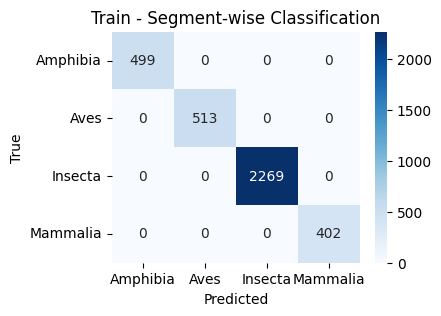


Classification Report (File-wise):
              precision    recall  f1-score   support

    Amphibia      1.000     1.000     1.000        96
        Aves      1.000     1.000     1.000        96
     Insecta      1.000     1.000     1.000        78
    Mammalia      1.000     1.000     1.000        63

    accuracy                          1.000       333
   macro avg      1.000     1.000     1.000       333
weighted avg      1.000     1.000     1.000       333



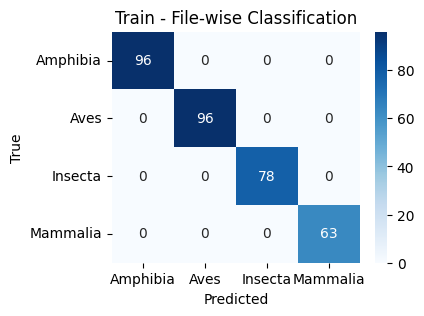



======================================== Validation Dataset Evaluation ========================================

==================== Validation - Segment-wise Evaluation ====================

Classification Report (Segment-wise):
              precision    recall  f1-score   support

    Amphibia      0.696     0.453     0.549        86
        Aves      0.672     0.672     0.672        58
     Insecta      0.829     0.934     0.878       197
    Mammalia      0.653     0.727     0.688        44

    accuracy                          0.764       385
   macro avg      0.713     0.697     0.697       385
weighted avg      0.756     0.764     0.752       385



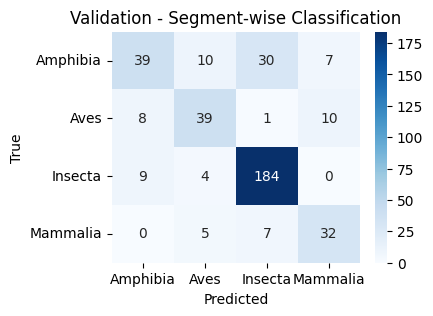


Classification Report (File-wise):
              precision    recall  f1-score   support

    Amphibia      0.750     0.500     0.600        12
        Aves      0.800     0.667     0.727        12
     Insecta      0.600     1.000     0.750         9
    Mammalia      0.667     0.667     0.667         9

    accuracy                          0.690        42
   macro avg      0.704     0.708     0.686        42
weighted avg      0.714     0.690     0.683        42



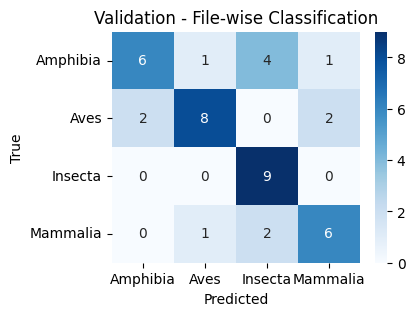



======================================== Test Dataset Evaluation ========================================

==================== Test - Segment-wise Evaluation ====================

Classification Report (Segment-wise):
              precision    recall  f1-score   support

    Amphibia      0.614     0.675     0.643        40
        Aves      0.432     0.800     0.561        40
     Insecta      0.934     0.893     0.913       318
    Mammalia      0.654     0.340     0.447        50

    accuracy                          0.804       448
   macro avg      0.659     0.677     0.641       448
weighted avg      0.829     0.804     0.806       448



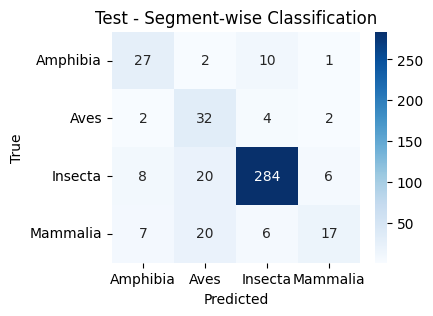


Classification Report (File-wise):
              precision    recall  f1-score   support

    Amphibia      0.800     0.667     0.727        12
        Aves      0.909     0.833     0.870        12
     Insecta      0.625     1.000     0.769        10
    Mammalia      0.800     0.500     0.615         8

    accuracy                          0.762        42
   macro avg      0.784     0.750     0.745        42
weighted avg      0.790     0.762     0.757        42



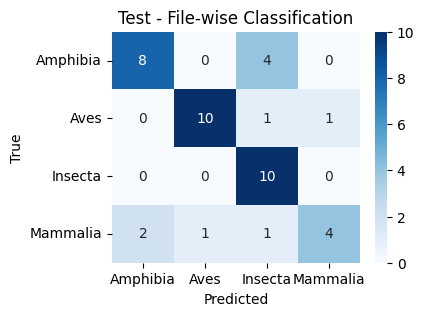

In [41]:
# Evaluation function
def evaluate_predictions(X, y_true, filenames, dataset_name):
    y_pred = model.predict(X)

    print(f"\n{'='*20} {dataset_name} - Segment-wise Evaluation {'='*20}")
    print("\nClassification Report (Segment-wise):")
    print(classification_report(y_true, y_pred, target_names=class_labels, digits=3))

    cm_segment = confusion_matrix(y_true, y_pred, labels=range(len(class_labels)))
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm_segment, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{dataset_name} - Segment-wise Classification")
    plt.show()

    # File-wise predictions (majority vote)
    file_preds = defaultdict(list)
    file_trues = {}
    for pred, true, fname in zip(y_pred, y_true, filenames):
        file_preds[fname].append(pred)
        if fname not in file_trues:
            file_trues[fname] = true

    final_preds, final_trues = [], []
    for fname in file_preds:
        final_preds.append(Counter(file_preds[fname]).most_common(1)[0][0])
        final_trues.append(file_trues[fname])

    print(f"\nClassification Report (File-wise):")
    print(classification_report(final_trues, final_preds, target_names=class_labels, digits=3))

    cm_file = confusion_matrix(final_trues, final_preds, labels=range(len(class_labels)))
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm_file, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{dataset_name} - File-wise Classification")
    plt.show()

# Evaluate
print(f"\n\n{'='*40} Train Dataset Evaluation {'='*40}")
evaluate_predictions(X_train, y_train, train_fnames, "Train")
print(f"\n\n{'='*40} Validation Dataset Evaluation {'='*40}")
evaluate_predictions(X_val, y_val, val_fnames, "Validation")
print(f"\n\n{'='*40} Test Dataset Evaluation {'='*40}")
evaluate_predictions(X_test, y_test, test_fnames, "Test")

### Efficientnet

Define Model

In [19]:


# Load pretrained EfficientNet-B0
weights = EfficientNet_B0_Weights.DEFAULT
effnet_model = efficientnet_b0(weights=weights)

# Update the classifier layer for your number of classes
effnet_model.classifier[1] = nn.Linear(effnet_model.classifier[1].in_features, len(train_dataset.classes))

Run experiment

In [20]:
# Datasets Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Use available device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")
effnet_model = effnet_model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(effnet_model.parameters(), lr=1e-5)

# Training loop with early stopping
best_val_loss = float('inf')
patience = 3
patience_counter = 0
best_model = None

for epoch in range(1, 101):
    effnet_model.train()
    running_loss = 0.0

    for inputs, labels, _ in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = effnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)

    # Validation
    effnet_model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for inputs, labels, _ in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = effnet_model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

    val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(effnet_model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered")
        break

# Load the best model
effnet_model.load_state_dict(best_model)

Using: cuda
Epoch 1: Train Loss = 1.3824, Val Loss = 1.3195
Epoch 2: Train Loss = 1.1961, Val Loss = 1.2338
Epoch 3: Train Loss = 1.0114, Val Loss = 1.1326
Epoch 4: Train Loss = 0.8499, Val Loss = 1.0360
Epoch 5: Train Loss = 0.7294, Val Loss = 0.9431
Epoch 6: Train Loss = 0.6245, Val Loss = 0.8579
Epoch 7: Train Loss = 0.5491, Val Loss = 0.8046
Epoch 8: Train Loss = 0.4800, Val Loss = 0.7719
Epoch 9: Train Loss = 0.4302, Val Loss = 0.7276
Epoch 10: Train Loss = 0.3675, Val Loss = 0.6712
Epoch 11: Train Loss = 0.3360, Val Loss = 0.6383
Epoch 12: Train Loss = 0.2953, Val Loss = 0.6254
Epoch 13: Train Loss = 0.2534, Val Loss = 0.6235
Epoch 14: Train Loss = 0.2344, Val Loss = 0.5946
Epoch 15: Train Loss = 0.2157, Val Loss = 0.5965
Epoch 16: Train Loss = 0.1925, Val Loss = 0.5719
Epoch 17: Train Loss = 0.1703, Val Loss = 0.5562
Epoch 18: Train Loss = 0.1696, Val Loss = 0.5603
Epoch 19: Train Loss = 0.1449, Val Loss = 0.5275
Epoch 20: Train Loss = 0.1382, Val Loss = 0.5330
Epoch 21: Train L

<All keys matched successfully>

In [23]:
# Assuming trained model, dataloaders, and class_names are available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Get class to idx dict
class_to_idx = train_dataset.class_to_idx
print(class_to_idx)

# Invert class_to_idx to map indices back to class names
idx_to_class = {v: k for k, v in class_to_idx.items()}
class_labels = [idx_to_class[i] for i in range(len(class_to_idx))]  # Ensure correct ordering
print(class_labels)

cuda
{'Amphibia': 0, 'Aves': 1, 'Insecta': 2, 'Mammalia': 3}
['Amphibia', 'Aves', 'Insecta', 'Mammalia']





 ======================================== Dataset: Train ========================================

Segment-wise Classification Report:
              precision    recall  f1-score   support

    Amphibia      0.986     0.986     0.986       438
        Aves      0.998     0.996     0.997       505
     Insecta      0.998     1.000     0.999      1782
    Mammalia      0.987     0.979     0.983       386

    accuracy                          0.995      3111
   macro avg      0.992     0.990     0.991      3111
weighted avg      0.995     0.995     0.995      3111



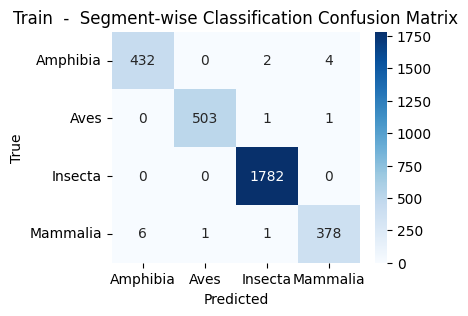


File-wise Classification Report:
              precision    recall  f1-score   support

    Amphibia      0.969     0.989     0.979        95
        Aves      1.000     1.000     1.000        94
     Insecta      1.000     1.000     1.000        78
    Mammalia      0.984     0.952     0.968        63

    accuracy                          0.988       330
   macro avg      0.988     0.985     0.987       330
weighted avg      0.988     0.988     0.988       330



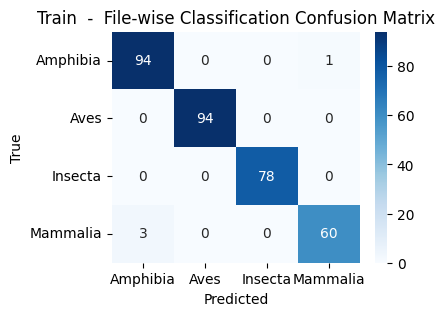




 ======================================== Dataset: Validation ========================================

Segment-wise Classification Report:
              precision    recall  f1-score   support

    Amphibia      0.843     0.738     0.787        80
        Aves      0.739     0.630     0.680        54
     Insecta      0.924     0.911     0.917       146
    Mammalia      0.609     0.886     0.722        44

    accuracy                          0.818       324
   macro avg      0.779     0.791     0.777       324
weighted avg      0.830     0.818     0.819       324



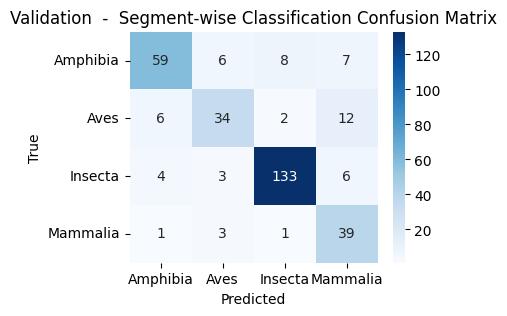


File-wise Classification Report:
              precision    recall  f1-score   support

    Amphibia      0.909     0.833     0.870        12
        Aves      0.889     0.800     0.842        10
     Insecta      1.000     0.889     0.941         9
    Mammalia      0.750     1.000     0.857         9

    accuracy                          0.875        40
   macro avg      0.887     0.881     0.877        40
weighted avg      0.889     0.875     0.876        40



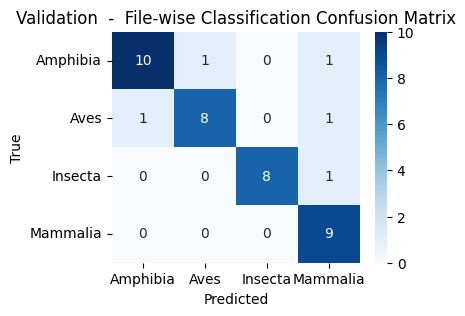




 ======================================== Dataset: Test ========================================

Segment-wise Classification Report:
              precision    recall  f1-score   support

    Amphibia      0.806     0.725     0.763        40
        Aves      0.569     0.825     0.673        40
     Insecta      0.940     0.940     0.940       267
    Mammalia      0.657     0.469     0.548        49

    accuracy                          0.848       396
   macro avg      0.743     0.740     0.731       396
weighted avg      0.854     0.848     0.847       396



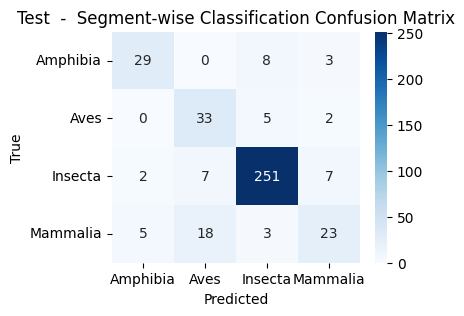


File-wise Classification Report:
              precision    recall  f1-score   support

    Amphibia      0.917     0.917     0.917        12
        Aves      0.833     0.833     0.833        12
     Insecta      0.818     0.900     0.857        10
    Mammalia      0.857     0.750     0.800         8

    accuracy                          0.857        42
   macro avg      0.856     0.850     0.852        42
weighted avg      0.858     0.857     0.856        42



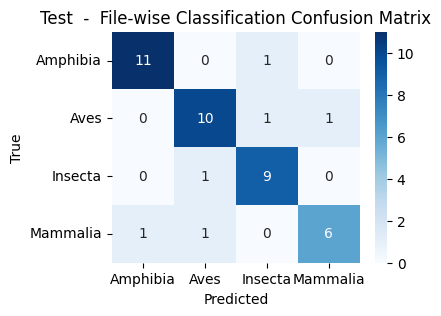

In [43]:
for dataset_name, dataloader in zip(["Train", "Validation", "Test"], [train_loader, val_loader, test_loader]):

    print(f"\n\n\n {'='*40} Dataset: {dataset_name} {'='*40}")

    # Get dataframe based on dataset
    df = train_df if dataset_name=="Train" else val_df if dataset_name=="Validation" else test_df

    model = effnet_model
    model.eval()

    segment_true, segment_pred = [], []
    file_predictions = {}

    with torch.no_grad():
        for inputs, labels, file_names in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)

            segment_true.extend(labels.cpu().numpy())
            segment_pred.extend(preds.cpu().numpy())

            for i, file_name in enumerate(file_names):
                if file_name not in file_predictions:
                    file_predictions[file_name] = []
                file_predictions[file_name].append(preds[i].item())

    # Classification report (Segment-wise)
    print("\nSegment-wise Classification Report:")
    print(classification_report(segment_true, segment_pred, target_names=class_labels, digits=3))

    # Segment-wise confusion matrix
    segment_cm = confusion_matrix(segment_true, segment_pred, labels=range(len(class_to_idx)))
    plt.figure(figsize=(4, 3))
    sns.heatmap(segment_cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{dataset_name}  -  Segment-wise Classification Confusion Matrix")
    plt.show()

    # Aggregate predictions to file level
    results = []
    for file_name, preds in file_predictions.items():
        # Get the true class index
        true_class_idx = class_to_idx[df.loc[df['filename'].str.contains(file_name, case=False, na=False), 'animal_class'].values[0]]
        most_common_pred = Counter(preds).most_common(1)[0][0]
        results.append({"filename": file_name, "predicted": most_common_pred, "true": true_class_idx})

    predictions_df = pd.DataFrame(results)

    # File-wise classification report
    print("\nFile-wise Classification Report:")
    print(classification_report(predictions_df['true'], predictions_df['predicted'], target_names=class_labels, digits=3))

    # File-wise confusion matrix
    file_cm = confusion_matrix(predictions_df['true'], predictions_df['predicted'], labels=range(len(class_labels)))
    plt.figure(figsize=(4, 3))
    sns.heatmap(file_cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{dataset_name}  -  File-wise Classification Confusion Matrix")
    plt.show()

### Resnet 18

In [25]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define ResNet Model
resnet_model = models.resnet18(pretrained=True)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, len(train_dataset.classes))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")
resnet_model = resnet_model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=1e-5)

# Training loop with early stopping
best_val_loss = float('inf')
patience = 3
patience_counter = 0
best_model = None

for epoch in range(1, 101):
    resnet_model.train()
    running_loss = 0.0

    for inputs, labels, _ in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = resnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)

    # Validation
    resnet_model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for inputs, labels, _ in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = resnet_model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

    val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = resnet_model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered")
        break

# Load the best model
resnet_model.load_state_dict(best_model)

/home/dzega/.conda/envs/audio_ml_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dzega/.conda/envs/audio_ml_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using: cuda
Epoch 1: Train Loss = 0.8726, Val Loss = 0.9852
Epoch 2: Train Loss = 0.4987, Val Loss = 0.8327
Epoch 3: Train Loss = 0.3444, Val Loss = 0.7686
Epoch 4: Train Loss = 0.2468, Val Loss = 0.7123
Epoch 5: Train Loss = 0.1809, Val Loss = 0.6747
Epoch 6: Train Loss = 0.1417, Val Loss = 0.6541
Epoch 7: Train Loss = 0.1116, Val Loss = 0.6408
Epoch 8: Train Loss = 0.0936, Val Loss = 0.6757
Epoch 9: Train Loss = 0.0707, Val Loss = 0.6425
Epoch 10: Train Loss = 0.0641, Val Loss = 0.6245
Epoch 11: Train Loss = 0.0456, Val Loss = 0.6180
Epoch 12: Train Loss = 0.0473, Val Loss = 0.6535
Epoch 13: Train Loss = 0.0328, Val Loss = 0.6058
Epoch 14: Train Loss = 0.0341, Val Loss = 0.5913
Epoch 15: Train Loss = 0.0316, Val Loss = 0.6608
Epoch 16: Train Loss = 0.0245, Val Loss = 0.6467
Epoch 17: Train Loss = 0.0235, Val Loss = 0.5975
Early stopping triggered


<All keys matched successfully>

In [26]:
# Assuming trained model, dataloaders, and class_names are available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Get class to idx dict
class_to_idx = train_dataset.class_to_idx
print(class_to_idx)

# Invert class_to_idx to map indices back to class names
idx_to_class = {v: k for k, v in class_to_idx.items()}
class_labels = [idx_to_class[i] for i in range(len(class_to_idx))]  # Ensure correct ordering
print(class_labels)

cuda
{'Amphibia': 0, 'Aves': 1, 'Insecta': 2, 'Mammalia': 3}
['Amphibia', 'Aves', 'Insecta', 'Mammalia']





 ======================================== Dataset: Train ========================================

Segment-wise Classification Report:
              precision    recall  f1-score   support

    Amphibia      1.000     0.998     0.999       438
        Aves      1.000     0.998     0.999       505
     Insecta      1.000     1.000     1.000      1782
    Mammalia      0.995     1.000     0.997       386

    accuracy                          0.999      3111
   macro avg      0.999     0.999     0.999      3111
weighted avg      0.999     0.999     0.999      3111



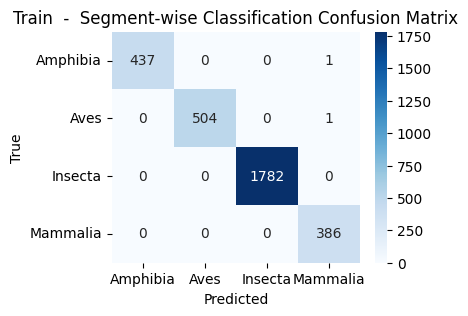


File-wise Classification Report:
              precision    recall  f1-score   support

    Amphibia      1.000     1.000     1.000        95
        Aves      1.000     1.000     1.000        94
     Insecta      1.000     1.000     1.000        78
    Mammalia      1.000     1.000     1.000        63

    accuracy                          1.000       330
   macro avg      1.000     1.000     1.000       330
weighted avg      1.000     1.000     1.000       330



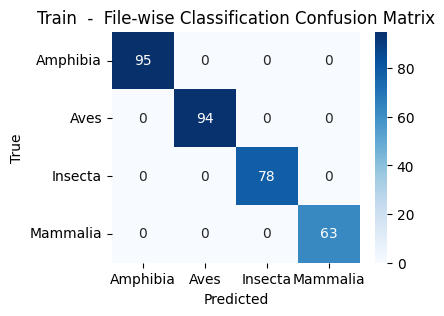




 ======================================== Dataset: Validation ========================================

Segment-wise Classification Report:
              precision    recall  f1-score   support

    Amphibia      0.774     0.812     0.793        80
        Aves      0.566     0.556     0.561        54
     Insecta      0.963     0.897     0.929       146
    Mammalia      0.549     0.636     0.589        44

    accuracy                          0.784       324
   macro avg      0.713     0.725     0.718       324
weighted avg      0.794     0.784     0.788       324



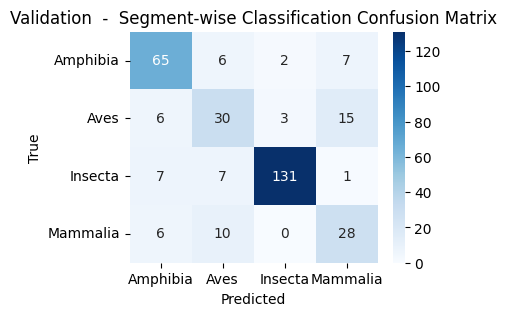


File-wise Classification Report:
              precision    recall  f1-score   support

    Amphibia      1.000     0.750     0.857        12
        Aves      0.571     0.800     0.667        10
     Insecta      0.875     0.778     0.824         9
    Mammalia      0.778     0.778     0.778         9

    accuracy                          0.775        40
   macro avg      0.806     0.776     0.781        40
weighted avg      0.815     0.775     0.784        40



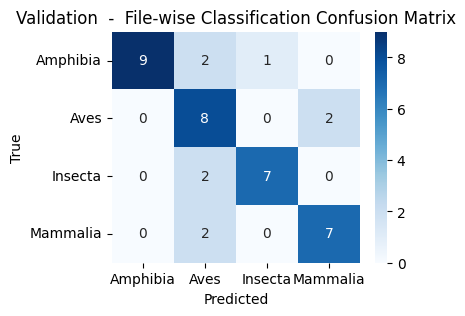




 ======================================== Dataset: Test ========================================

Segment-wise Classification Report:
              precision    recall  f1-score   support

    Amphibia      0.830     0.975     0.897        40
        Aves      0.618     0.850     0.716        40
     Insecta      0.984     0.918     0.950       267
    Mammalia      0.644     0.592     0.617        49

    accuracy                          0.876       396
   macro avg      0.769     0.834     0.795       396
weighted avg      0.889     0.876     0.879       396



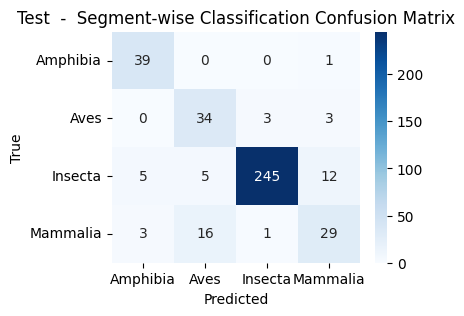


File-wise Classification Report:
              precision    recall  f1-score   support

    Amphibia      0.800     1.000     0.889        12
        Aves      0.917     0.917     0.917        12
     Insecta      1.000     0.800     0.889        10
    Mammalia      0.714     0.625     0.667         8

    accuracy                          0.857        42
   macro avg      0.858     0.835     0.840        42
weighted avg      0.865     0.857     0.854        42



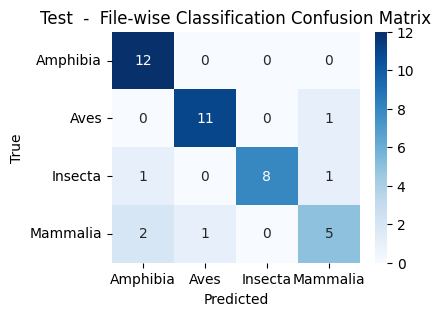

In [44]:
for dataset_name, dataloader in zip(["Train", "Validation", "Test"], [train_loader, val_loader, test_loader]):

    print(f"\n\n\n {'='*40} Dataset: {dataset_name} {'='*40}")

    # Get dataframe based on dataset
    df = train_df if dataset_name=="Train" else val_df if dataset_name=="Validation" else test_df

    model = resnet_model
    model.eval()

    segment_true, segment_pred = [], []
    file_predictions = {}

    with torch.no_grad():
        for inputs, labels, file_names in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)

            segment_true.extend(labels.cpu().numpy())
            segment_pred.extend(preds.cpu().numpy())

            for i, file_name in enumerate(file_names):
                if file_name not in file_predictions:
                    file_predictions[file_name] = []
                file_predictions[file_name].append(preds[i].item())

    # Classification report (Segment-wise)
    print("\nSegment-wise Classification Report:")
    print(classification_report(segment_true, segment_pred, target_names=class_labels, digits=3))

    # Segment-wise confusion matrix
    segment_cm = confusion_matrix(segment_true, segment_pred, labels=range(len(class_to_idx)))
    plt.figure(figsize=(4, 3))
    sns.heatmap(segment_cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{dataset_name}  -  Segment-wise Classification Confusion Matrix")
    plt.show()

    # Aggregate predictions to file level
    results = []
    for file_name, preds in file_predictions.items():
        # Get the true class index
        true_class_idx = class_to_idx[df.loc[df['filename'].str.contains(file_name, case=False, na=False), 'animal_class'].values[0]]
        most_common_pred = Counter(preds).most_common(1)[0][0]
        results.append({"filename": file_name, "predicted": most_common_pred, "true": true_class_idx})

    predictions_df = pd.DataFrame(results)

    # File-wise classification report
    print("\nFile-wise Classification Report:")
    print(classification_report(predictions_df['true'], predictions_df['predicted'], target_names=class_labels, digits=3))

    # File-wise confusion matrix
    file_cm = confusion_matrix(predictions_df['true'], predictions_df['predicted'], labels=range(len(class_labels)))
    plt.figure(figsize=(4, 3))
    sns.heatmap(file_cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{dataset_name}  -  File-wise Classification Confusion Matrix")
    plt.show()